In [1]:
# Run this only once if packages are missing
# !pip install pandas numpy matplotlib statsmodels scikit-learn yfinance pmdarima

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import yfinance as yf

plt.style.use("seaborn-v0_8")

In [2]:
df = yf.download("AAPL", start="1980-01-01", end="2023-12-31", progress=False)
df = df[['Close']].rename(columns={'Close': 'Price'})
print(df.head())

Price          Price
Ticker          AAPL
Date                
1980-12-12  0.098390
1980-12-15  0.093256
1980-12-16  0.086412
1980-12-17  0.088550
1980-12-18  0.091118


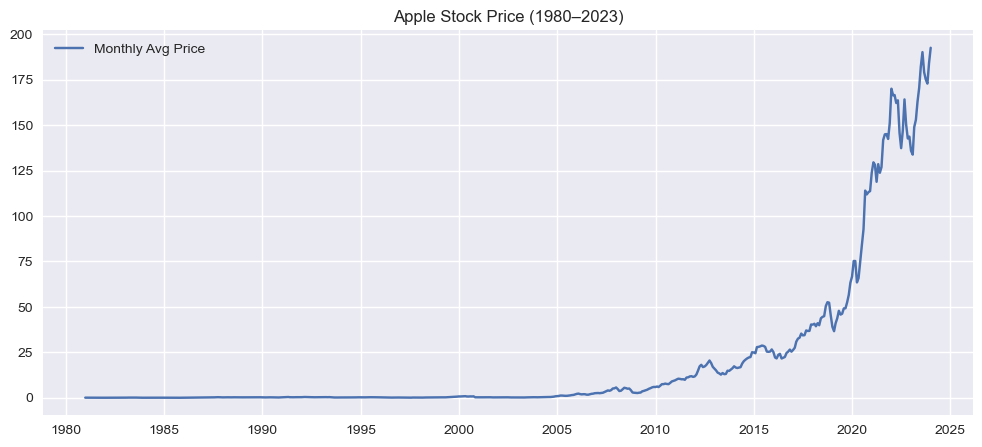

In [5]:
# Convert to monthly average
monthly = df['Price'].resample('ME').mean()

# Plot monthly trend
plt.figure(figsize=(12, 5))
plt.plot(monthly, label='Monthly Avg Price')
plt.title('Apple Stock Price (1980–2023)')
plt.legend()
plt.show()

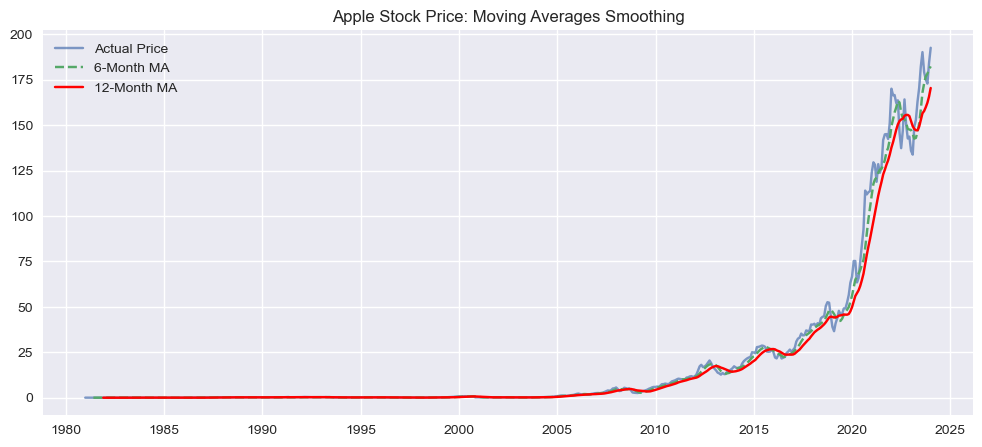

In [7]:
# Make sure 'monthly' is a DataFrame with 'Price' column
monthly = df.resample('ME').mean()

# Calculate 6-month and 12-month moving averages
monthly['MA_6'] = monthly['Price'].rolling(window=6).mean()
monthly['MA_12'] = monthly['Price'].rolling(window=12).mean()

# Plot actual vs moving averages
plt.figure(figsize=(12, 5))
plt.plot(monthly['Price'], label='Actual Price', alpha=0.7)
plt.plot(monthly['MA_6'], label='6-Month MA', linestyle='--')
plt.plot(monthly['MA_12'], label='12-Month MA', color='red')
plt.title('Apple Stock Price: Moving Averages Smoothing')
plt.legend()
plt.show()

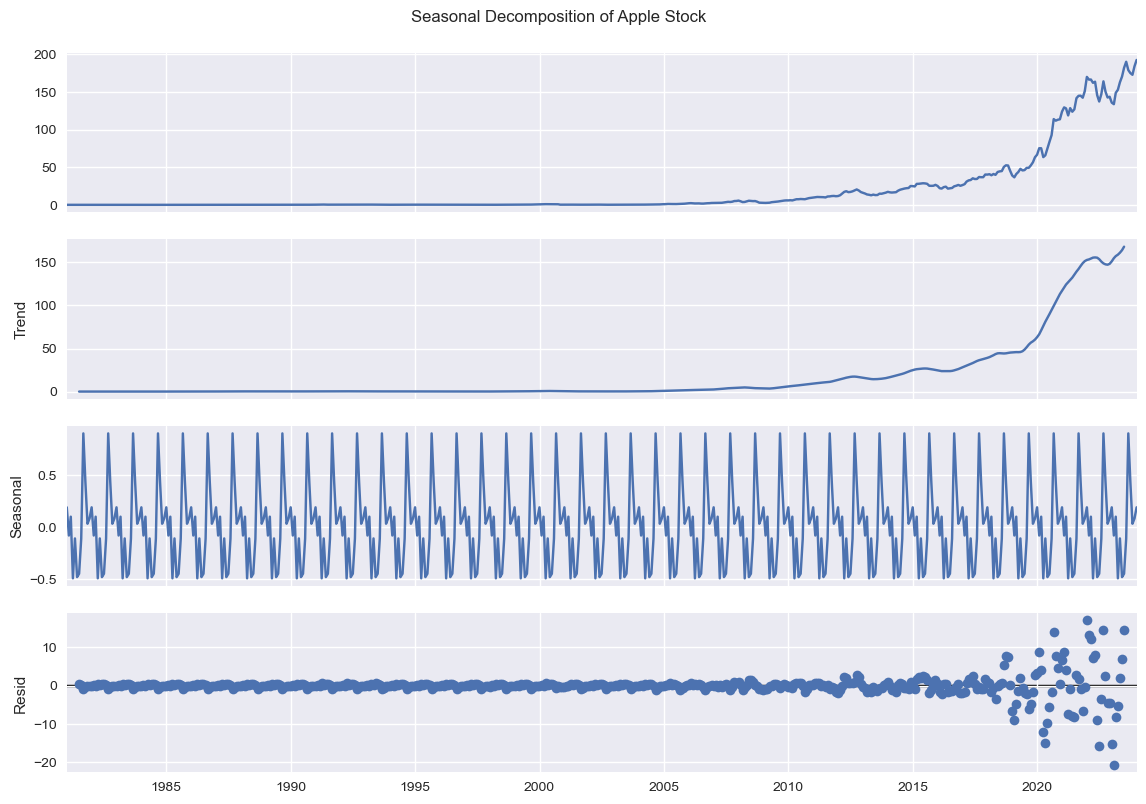

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose monthly Apple stock prices
decomp = seasonal_decompose(monthly['Price'], model='additive', period=12)

fig = decomp.plot()
fig.set_size_inches(12, 8)
plt.suptitle('Seasonal Decomposition of Apple Stock', y=1.02)
plt.show()

In [9]:
# Use last 12 months for testing
train = monthly['Price'].iloc[:-12]
test = monthly['Price'].iloc[-12:]

print("Train:", train.index.min(), "→", train.index.max())
print("Test:", test.index.min(), "→", test.index.max())

Train: 1980-12-31 00:00:00 → 2022-12-31 00:00:00
Test: 2023-01-31 00:00:00 → 2023-12-31 00:00:00


In [10]:
train_log = np.log(train)
test_log = np.log(test)

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Seasonal ARIMA: (p,d,q) x (P,D,Q, m) with monthly seasonality m=12
model = ARIMA(train_log, order=(2,1,1), seasonal_order=(1,1,1,12))
result = model.fit()

# Forecast steps equal to test length
forecast_log = result.forecast(steps=len(test_log))
forecast = np.exp(forecast_log)  # inverse transform

C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\LENOVO\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [12]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse:.2f} USD")

RMSE: 25.83 USD


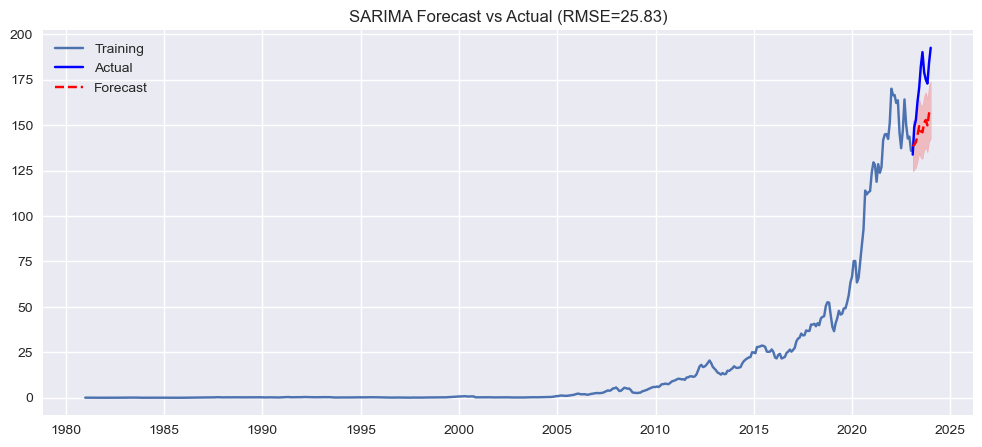

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')

# Simple ±10% band around forecast
plt.fill_between(test.index, forecast*0.9, forecast*1.1, alpha=0.2, color='red')

plt.title(f"SARIMA Forecast vs Actual (RMSE={rmse:.2f})")
plt.legend()
plt.show()